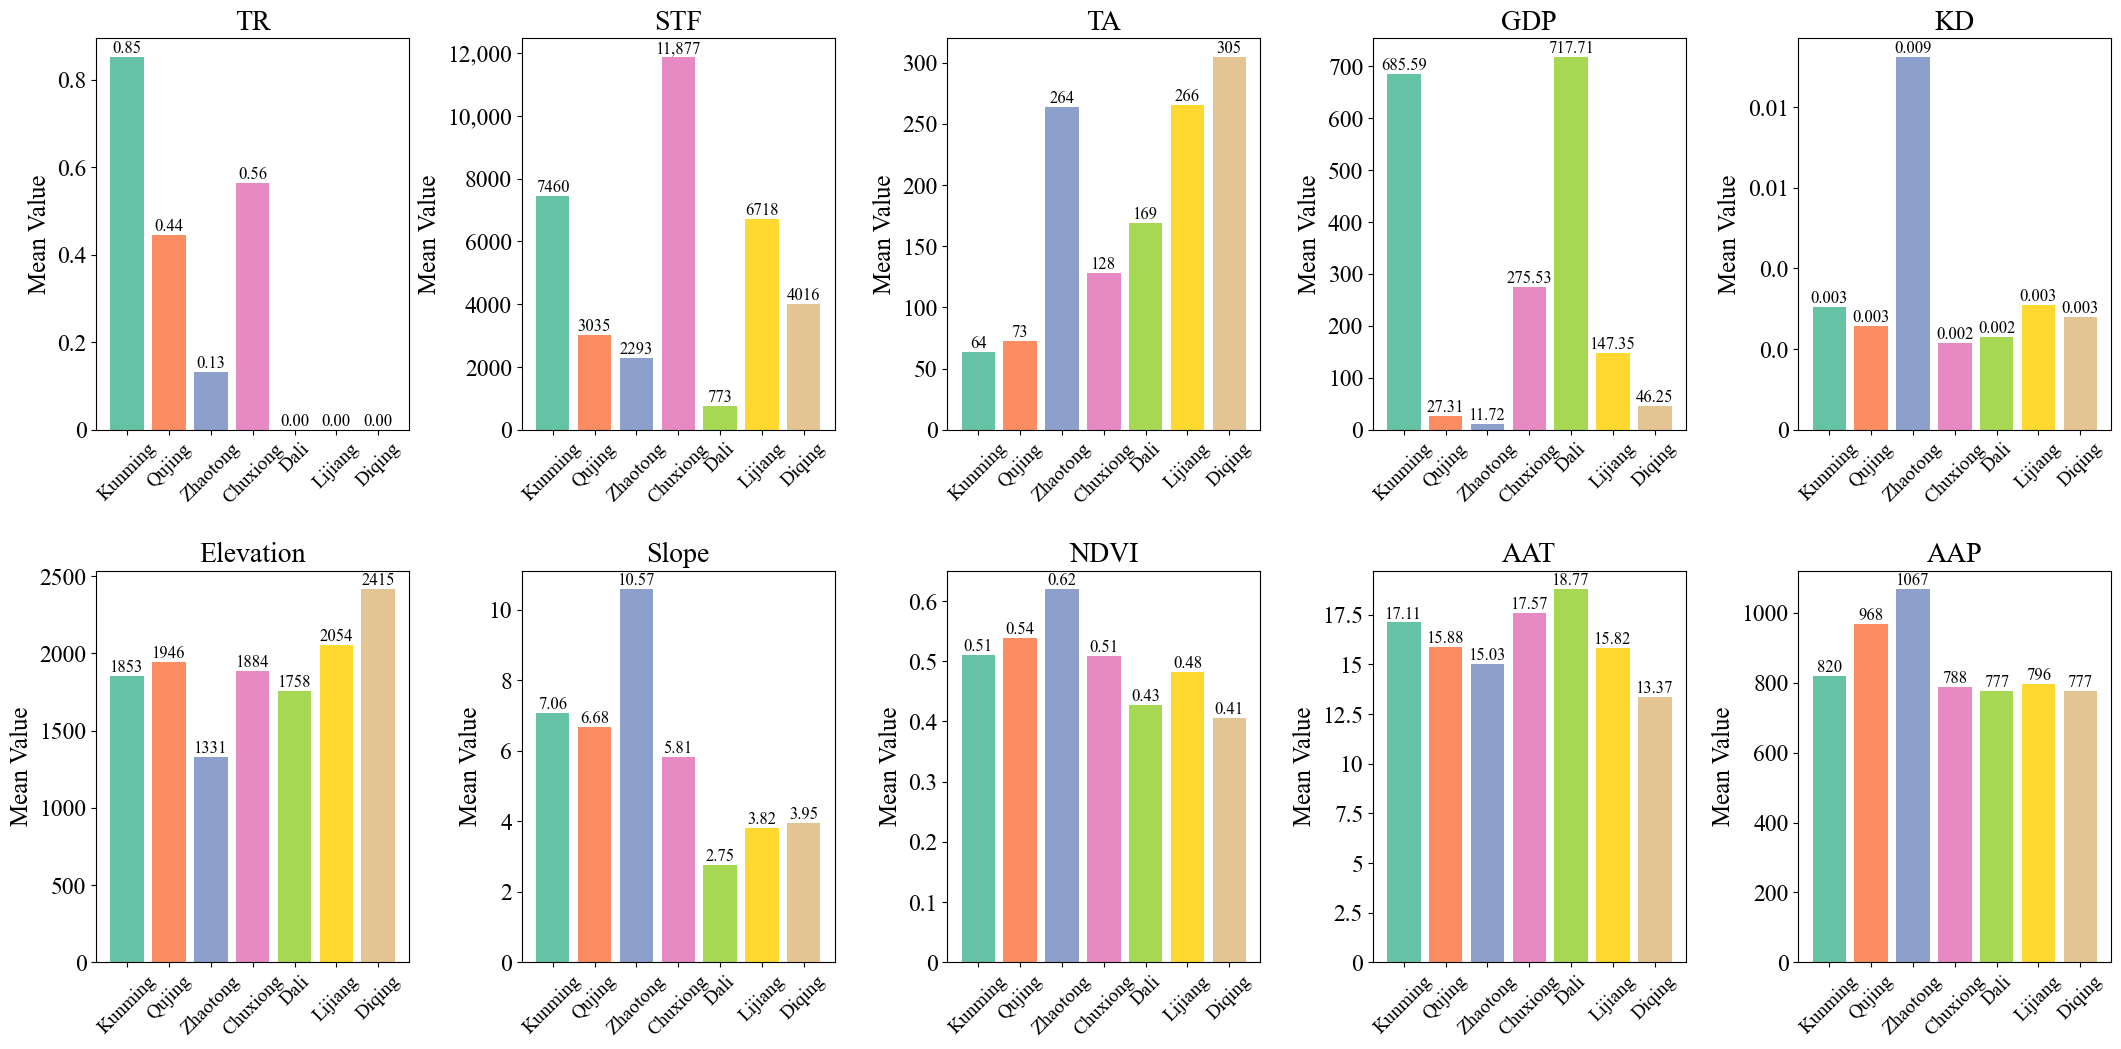

In [ ]:
# 指标数值分布格局统计
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.patches import Patch
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 设置字体：中文宋体 + 英文 Times New Roman
# zh_font = font_manager.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")  # 宋体
plt.rcParams['font.family'] = 'Times New Roman'  # 英文
plt.rcParams['axes.unicode_minus'] = False  # 负号

# 读取Excel文件
file_path = r"C:\Users\leishen\Desktop\sample.xlsx"
df = pd.read_excel(file_path)

# 需要统计的字段
fields = [
    "TR", "STF", "TA", "GDP", "KD",
    "Elevation", "Slope", "NDVI", "AAT", "AAP"
]

# 分组求均值
grouped = df.groupby('城市')[fields].mean()

# 按指定城市顺序排序
city_order = ['Kunming', 'Qujing', 'Zhaotong', 'Chuxiong', 'Dali', 'Lijiang', 'Diqing']
grouped = grouped.reindex(city_order)

# 使用 SCI 风格配色（Set2调色板）
palette = sns.color_palette("Set2", n_colors=len(grouped.index))
city_list = grouped.index.tolist()
color_map = {city: palette[i] for i, city in enumerate(city_list)}

# y 轴刻度格式化函数：整数 ≥10000 加千位分隔符
def y_formatter(x, pos):
    if float(x).is_integer():  # 整数
        val = int(round(x))
        if abs(val) >= 10000:
            return f"{val:,}"
        else:
            return str(val)
    else:  # 小数
        return str(round(x, 2))  # 保留 2 位

# 创建2行5列子图
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(26, 12))
axes = axes.flatten()
plt.subplots_adjust(hspace=0.36, wspace=0.36)  # 行间距和列间距加大

# 绘图
for i, field in enumerate(fields):
    ax = axes[i]
    data = grouped[field]
    bars = ax.bar(data.index, data.values, color=[color_map[city] for city in data.index])
    
    ax.set_title(field, fontsize=20)  # 子图标题
    ax.set_ylabel('Mean Value', fontsize=18)
    ax.set_xlabel('', fontsize=16)
    
    ax.set_xticks(range(len(data.index)))
    ax.set_xticklabels(data.index, rotation=45, fontsize=14)  # x轴标签更大
    ax.tick_params(axis='y', labelsize=17)  # y轴刻度更大

    # 设置 y 轴刻度格式
    ax.yaxis.set_major_formatter(FuncFormatter(y_formatter))

    # 添加柱顶数值标签
    for bar in bars:
        height = bar.get_height()

        if field == 'KD':  # 三位小数
            label = f"{round(height, 3):.3f}"
        elif field in ['STF', 'AAP', 'Elevation', 'TA']:  # 整数显示
            val = int(round(height))
            if abs(val) >= 10000:
                label = f"{val:,}"
            else:
                label = str(val)
        else:  # 保留两位小数
            label = f"{round(height, 2):.2f}"

        ax.text(bar.get_x() + bar.get_width() / 2, height, label,
                ha='center', va='bottom', fontsize=12)

# 删除多余子图
for j in range(len(fields), len(axes)):
    fig.delaxes(axes[j])

# 保存为高清图
plt.savefig("格局统计图.png", dpi=600, bbox_inches='tight')
plt.show()


d:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 系统找不到指定的文件。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "d:\Anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\Anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
d:\A

📊 特征权重（从高到低）:
AAT: 0.3315
TR: 0.2403
AAP: 0.2118
TA: 0.1224
NDVI: 0.0675
KD: 0.0255
Elevation: 0.0007
Slope: 0.0002
GDP: 0.0001
STF: 0.0000


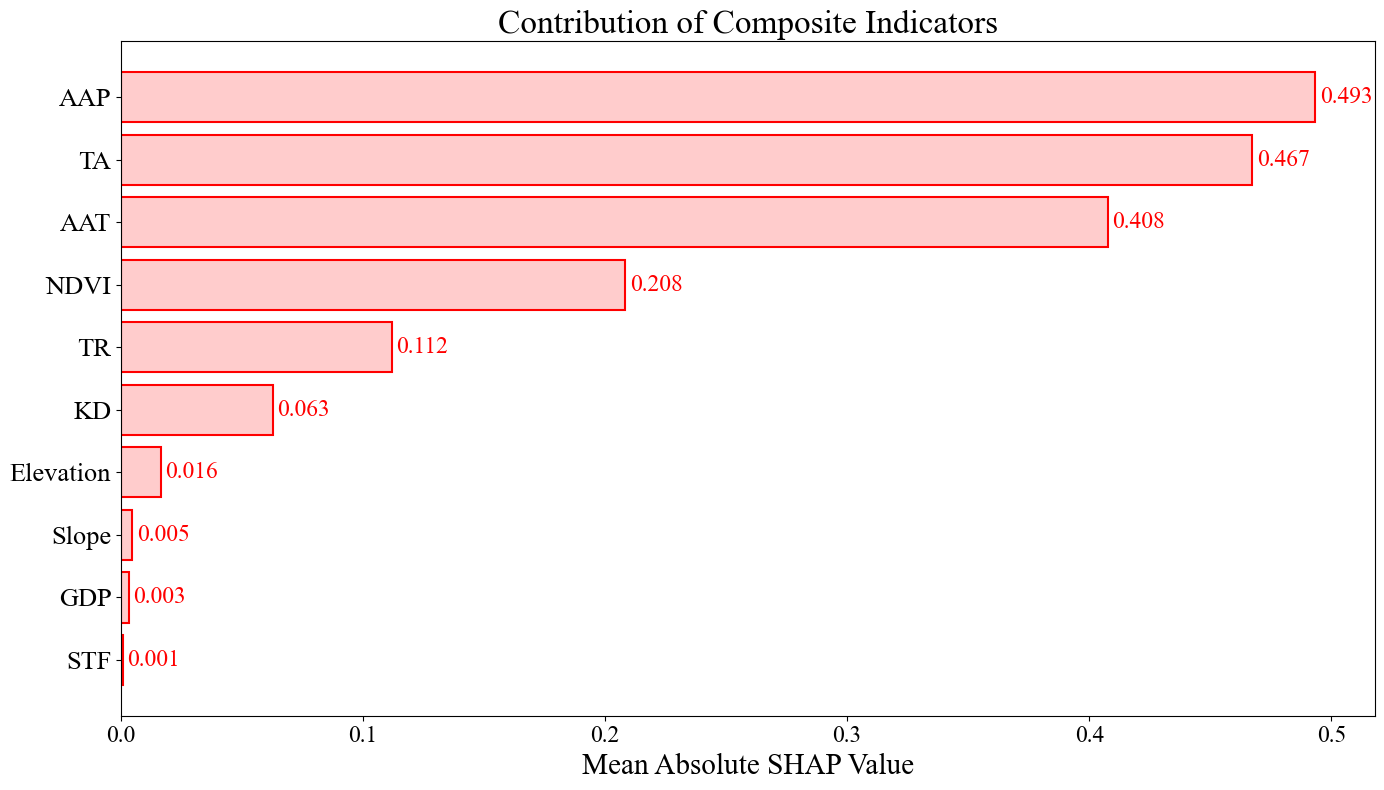

In [ ]:
# 混合模式指标SHAP分析
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
from matplotlib import font_manager

# 设置字体：中文宋体 + 英文 Times New Roman
zh_font = font_manager.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")  # 宋体
plt.rcParams['font.family'] = 'Times New Roman'  # 英文
plt.rcParams['axes.unicode_minus'] = False  # 负号

# 1. 读取数据
file_path = r"C:\Users\leishen\Desktop\sample.xlsx"
df = pd.read_excel(file_path)

# 2. 选择指定列
selected_cols = [
    "TA", "KD", "GDP", "AAT",
    "NDVI", "AAP", "Elevation", "Slope", "TR", "STF"
]
data = df[selected_cols].copy()

# 3. 负向指标正向化（交通可达性、坡度）
neg_cols = ["TA", "Slope"]
for col in neg_cols:
    data[col] = data[col].max() - data[col]

# 4. Min-Max 标准化（缩放到0~1）
scaler = MinMaxScaler()
data_std = scaler.fit_transform(data)

# 5. 平移处理（整体+1，使其变为 1~2 范围）
data_shifted = data_std + 1

# 6. KMeans聚类分级（等级：1~5）
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_shifted)
cluster_labels = clusters + 1  # 标签从1~5

# 7. XGBoost训练，计算特征权重
xgb_model = XGBRegressor(n_estimators=100, random_state=41)
xgb_model.fit(data_shifted, cluster_labels)
feature_importances = xgb_model.feature_importances_

# 8. 输出特征权重（按大小排序）
feature_weight_dict = dict(zip(selected_cols, feature_importances))
sorted_weights = sorted(feature_weight_dict.items(), key=lambda x: x[1], reverse=True)

print("📊 特征权重（从高到低）:")
for feature, weight in sorted_weights:
    print(f"{feature}: {weight:.4f}")

# 9. 加权得分（使用 Min-Max 标准化后的数据，不是平移后的）
weighted_score = data_std @ feature_importances

# ✅ 乘以 100 放大得分
weighted_score = weighted_score * 100

# 10. 添加得分列并写回Excel
df["总分值"] = weighted_score
df.to_excel(file_path, index=False)

# ——— 新增：基于训练好的xgb模型做SHAP解释 ———
explainer = shap.Explainer(xgb_model)
shap_values = explainer(data_shifted)

# 计算每个特征的平均绝对SHAP值（重要度）
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
features = selected_cols

# 排序（降序），确保顶部最大
sorted_idx = np.argsort(mean_abs_shap)[::-1]
mean_abs_shap_sorted = mean_abs_shap[sorted_idx]
features_sorted = [features[i] for i in sorted_idx]

# 准备中文宋体和Times New Roman字体（Windows系统）
font_zh = fm.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")  # 宋体
font_en = fm.FontProperties(family='Times New Roman')

# 绘制自定义SHAP特征重要性横向条形图（自上向下排序）
fig, ax = plt.subplots(figsize=(14, 8))

bars = ax.barh(
    features_sorted[::-1],           # 反转顺序，保证最大值在上
    mean_abs_shap_sorted[::-1],      # 反转顺序对应
    color='#FFCCCC',                 # 浅红色填充
    edgecolor='red',                 # 红色边框
    linewidth=1.5
)

# 在柱头（条形右端）添加SHAP值标签，保留两位小数
for bar, val in zip(bars, mean_abs_shap_sorted[::-1]):
    width = bar.get_width()
    ax.text(
        width + 0.002,                # 稍微向右偏移一点，避免重叠柱子
        bar.get_y() + bar.get_height() / 2,
        f"{val:.3f}",
        ha='left', va='center',
        fontproperties=font_en,
        fontsize=17,
        color='red'
    )

# 设置字体（y轴刻度标签用中文宋体）
ax.set_yticks(np.arange(len(features_sorted)))
ax.set_yticklabels(features_sorted[::-1], fontsize=19)

# x轴标签
ax.set_xlabel("Mean Absolute SHAP Value", fontsize=21)
# x轴刻度字体大小设置
ax.tick_params(axis='x', labelsize=17)  # 这里的16可以根据需要调大或调小

# 标题
ax.set_title("Contribution of Composite Indicators", fontsize=24)

# 无网格线
ax.grid(False)

plt.tight_layout()
plt.savefig("all_shap_feature_importance_600dpi.png", dpi=600)
plt.show()

d:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


📊 特征权重（从高到低）:
KD: 0.5810
TA: 0.3830
TR: 0.0360
GDP: 0.0000
STF: 0.0000


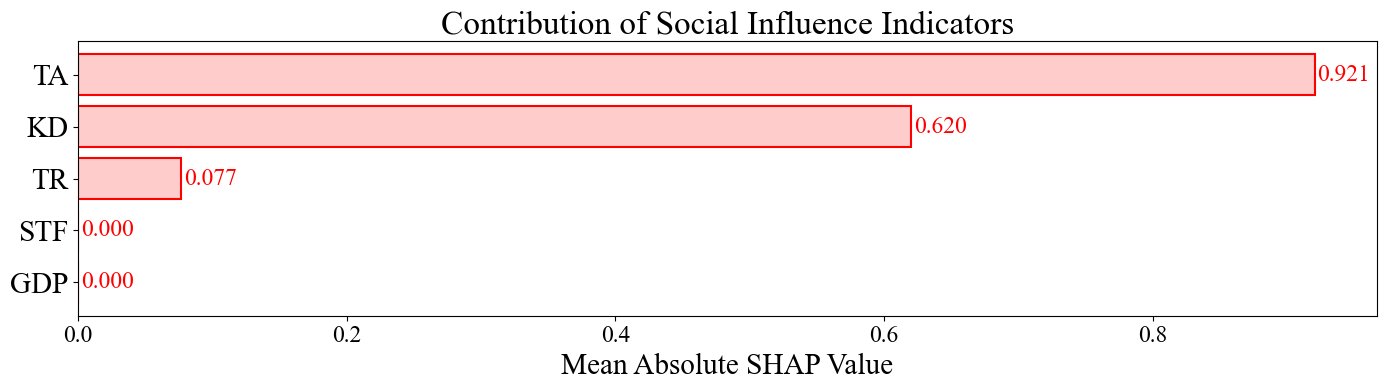

In [ ]:
# 社会模式指标SHAP分析
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Times New Roman'

# 1. 读取数据
file_path = r"C:\Users\leishen\Desktop\sample.xlsx"
df = pd.read_excel(file_path)

# 2. 选择指定列
selected_cols = [
    "TA", "KD", "GDP", "TR", "STF"
]
data = df[selected_cols].copy()

# 3. 负向指标正向化（交通可达性、坡度）
neg_cols = ["TA"]
for col in neg_cols:
    data[col] = data[col].max() - data[col]

# 4. Min-Max 标准化（缩放到0~1）
scaler = MinMaxScaler()
data_std = scaler.fit_transform(data)

# 5. 平移处理（整体+1，使其变为 1~2 范围）
data_shifted = data_std + 1

# 6. KMeans聚类分级（等级：1~5）
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_shifted)
cluster_labels = clusters + 1  # 标签从1~5

# 7. XGBoost训练，计算特征权重
xgb_model = XGBRegressor(n_estimators=100, random_state=41)
xgb_model.fit(data_shifted, cluster_labels)
feature_importances = xgb_model.feature_importances_

# 8. 输出特征权重（按大小排序）
feature_weight_dict = dict(zip(selected_cols, feature_importances))
sorted_weights = sorted(feature_weight_dict.items(), key=lambda x: x[1], reverse=True)

print("📊 特征权重（从高到低）:")
for feature, weight in sorted_weights:
    print(f"{feature}: {weight:.4f}")

# 9. 加权得分（使用 Min-Max 标准化后的数据，不是平移后的）
weighted_score = data_std @ feature_importances

# ✅ 乘以 100 放大得分
weighted_score = weighted_score * 100

# 10. 添加得分列并写回Excel
df["人为总分值"] = weighted_score
df.to_excel(file_path, index=False)

# ——— 新增：基于训练好的xgb模型做SHAP解释 ———
explainer = shap.Explainer(xgb_model)
shap_values = explainer(data_shifted)

# 计算每个特征的平均绝对SHAP值（重要度）
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
features = selected_cols

# 排序（降序），确保顶部最大
sorted_idx = np.argsort(mean_abs_shap)[::-1]
mean_abs_shap_sorted = mean_abs_shap[sorted_idx]
features_sorted = [features[i] for i in sorted_idx]

# 准备中文宋体和Times New Roman字体（Windows系统）
# font_zh = fm.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")  # 宋体
# font_en = fm.FontProperties(family='Times New Roman')

# 绘制自定义SHAP特征重要性横向条形图（自上向下排序）
fig, ax = plt.subplots(figsize=(14, 4))

bars = ax.barh(
    features_sorted[::-1],           # 反转顺序，保证最大值在上
    mean_abs_shap_sorted[::-1],      # 反转顺序对应
    color='#FFCCCC',                 # 浅红色填充
    edgecolor='red',                 # 红色边框
    linewidth=1.5
)

# 在柱头（条形右端）添加SHAP值标签，保留两位小数
for bar, val in zip(bars, mean_abs_shap_sorted[::-1]):
    width = bar.get_width()
    ax.text(
        width + 0.002,                # 稍微向右偏移一点，避免重叠柱子
        bar.get_y() + bar.get_height() / 2,
        f"{val:.3f}",
        ha='left', va='center',
        fontproperties=font_en,
        fontsize=17,
        color='red'
    )

# 设置字体（y轴刻度标签用中文宋体）
ax.set_yticks(np.arange(len(features_sorted)))
ax.set_yticklabels(features_sorted[::-1], fontsize=21)

# x轴标签
ax.set_xlabel("Mean Absolute SHAP Value", fontsize=21)
# x轴刻度字体大小设置
ax.tick_params(axis='x', labelsize=17)  # 这里的16可以根据需要调大或调小

# 标题
ax.set_title("Contribution of Social Influence Indicators", fontsize=24)

# 无网格线
ax.grid(False)

plt.tight_layout()
plt.savefig("people_shap_feature_importance_600dpi.png", dpi=600)
plt.show()

d:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


📊 特征权重（从高到低）:
AAT: 0.4238
AAP: 0.3174
Slope: 0.2164
NDVI: 0.0299
Elevation: 0.0124


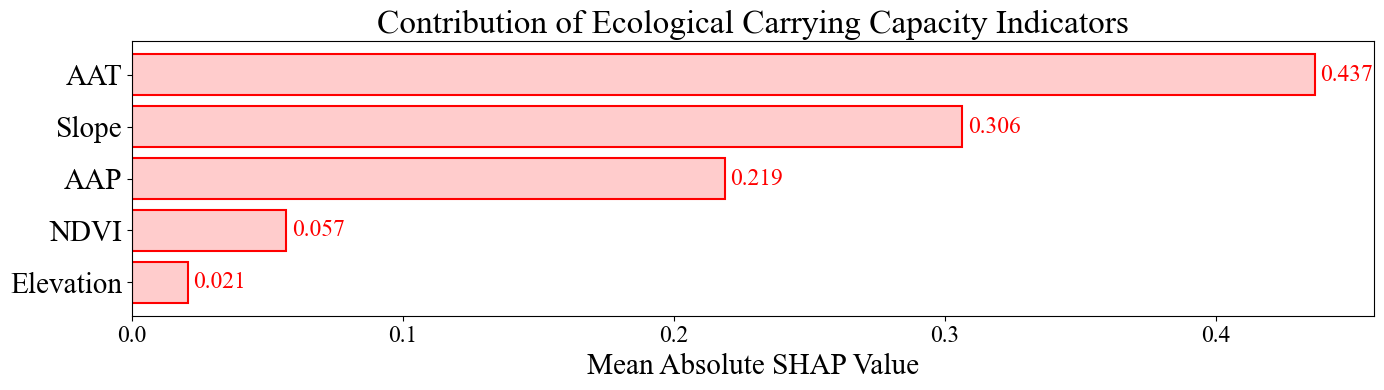

In [ ]:
# 生态模式指标SHAP分析
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Times New Roman'

# 1. 读取数据
file_path = r"C:\Users\leishen\Desktop\sample.xlsx"
df = pd.read_excel(file_path)

# 2. 选择指定列
selected_cols = [
    "AAT", "NDVI", "AAP", "Elevation", "Slope"
]
data = df[selected_cols].copy()

# 3. 负向指标正向化（交通可达性、坡度）
neg_cols = ["Slope"]
for col in neg_cols:
    data[col] = data[col].max() - data[col]

# 4. Min-Max 标准化（缩放到0~1）
scaler = MinMaxScaler()
data_std = scaler.fit_transform(data)

# 5. 平移处理（整体+1，使其变为 1~2 范围）
data_shifted = data_std + 1

# 6. KMeans聚类分级（等级：1~5）
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_shifted)
cluster_labels = clusters + 1  # 标签从1~5

# 7. XGBoost训练，计算特征权重
xgb_model = XGBRegressor(n_estimators=100, random_state=41)
xgb_model.fit(data_shifted, cluster_labels)
feature_importances = xgb_model.feature_importances_

# 8. 输出特征权重（按大小排序）
feature_weight_dict = dict(zip(selected_cols, feature_importances))
sorted_weights = sorted(feature_weight_dict.items(), key=lambda x: x[1], reverse=True)

print("📊 特征权重（从高到低）:")
for feature, weight in sorted_weights:
    print(f"{feature}: {weight:.4f}")

# 9. 加权得分（使用 Min-Max 标准化后的数据，不是平移后的）
weighted_score = data_std @ feature_importances

# ✅ 乘以 100 放大得分
weighted_score = weighted_score * 100

# 10. 添加得分列并写回Excel
df["生态总分值"] = weighted_score
df.to_excel(file_path, index=False)

# ——— 新增：基于训练好的xgb模型做SHAP解释 ———
explainer = shap.Explainer(xgb_model)
shap_values = explainer(data_shifted)

# 计算每个特征的平均绝对SHAP值（重要度）
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
features = selected_cols

# 排序（降序），确保顶部最大
sorted_idx = np.argsort(mean_abs_shap)[::-1]
mean_abs_shap_sorted = mean_abs_shap[sorted_idx]
features_sorted = [features[i] for i in sorted_idx]

# 准备中文宋体和Times New Roman字体（Windows系统）
# font_zh = fm.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")  # 宋体
# 全局字体设置为Times New Roman


# 绘制自定义SHAP特征重要性横向条形图（自上向下排序）
fig, ax = plt.subplots(figsize=(14, 4))

bars = ax.barh(
    features_sorted[::-1],           # 反转顺序，保证最大值在上
    mean_abs_shap_sorted[::-1],      # 反转顺序对应
    color='#FFCCCC',                 # 浅红色填充
    edgecolor='red',                 # 红色边框
    linewidth=1.5
)

# 在柱头（条形右端）添加SHAP值标签，保留两位小数
for bar, val in zip(bars, mean_abs_shap_sorted[::-1]):
    width = bar.get_width()
    ax.text(
        width + 0.002,                # 稍微向右偏移一点，避免重叠柱子
        bar.get_y() + bar.get_height() / 2,
        f"{val:.3f}",
        ha='left', va='center',
        fontproperties=font_en,
        fontsize=17,
        color='red'
    )

# 设置字体（y轴刻度标签用中文宋体）
ax.set_yticks(np.arange(len(features_sorted)))
ax.set_yticklabels(features_sorted[::-1], fontsize=21)

# x轴标签
ax.set_xlabel("Mean Absolute SHAP Value", fontsize=21)
# x轴刻度字体大小设置
ax.tick_params(axis='x', labelsize=17)  # 这里的16可以根据需要调大或调小

# 标题
ax.set_title("Contribution of Ecological Carrying Capacity Indicators", fontsize=24)

# 无网格线
ax.grid(False)

plt.tight_layout()
plt.savefig("vage_shap_feature_importance_600dpi.png", dpi=600)
plt.show()

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

# 设置字体：中文宋体 + 英文 Times New Roman
# zh_font = font_manager.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")  # 宋体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
file_path = r"C:\Users\leishen\Desktop\sample.xlsx"
df = pd.read_excel(file_path)

# 分析字段和城市排序
fields = ['人为总分值', '生态总分值', '总分值']
city_order = ['Kunming', 'Qujing', 'Zhaotong', 'Chuxiong', 'Dali', 'Lijiang', 'Diqing']

# 分组并按城市排序
grouped = df.groupby('城市')[fields].mean()
grouped = grouped.reindex(city_order)

# 配色方案
palette = sns.color_palette("Set2", n_colors=len(city_order))
color_map = {city: palette[i] for i, city in enumerate(city_order)}

# 遍历字段，单独画图并保存
for field in fields:
    data = grouped[field]

    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 设置更小的柱宽
    bars = ax.bar(data.index, data.values, width=0.5,
                  color=[color_map[city] for city in data.index])
    
    # 去除顶部和右边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # 设置坐标轴
    ax.set_xlabel('')
    ax.set_ylabel('Score', fontsize=30)
    ax.set_xticks(range(len(data.index)))
    ax.set_xticklabels(data.index, rotation=45, fontsize=28)
    ax.tick_params(axis='y', labelsize=28)

    # 添加柱顶标签：紧贴柱头之上
    for bar in bars:
        height = bar.get_height()
        label = f'{height:.2f}'
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, label,
                ha='center', va='bottom', fontsize=26)

    # 保存图像
    save_name = f"{field}.png"
    plt.savefig(save_name, dpi=600, bbox_inches='tight')
    plt.close(fig)

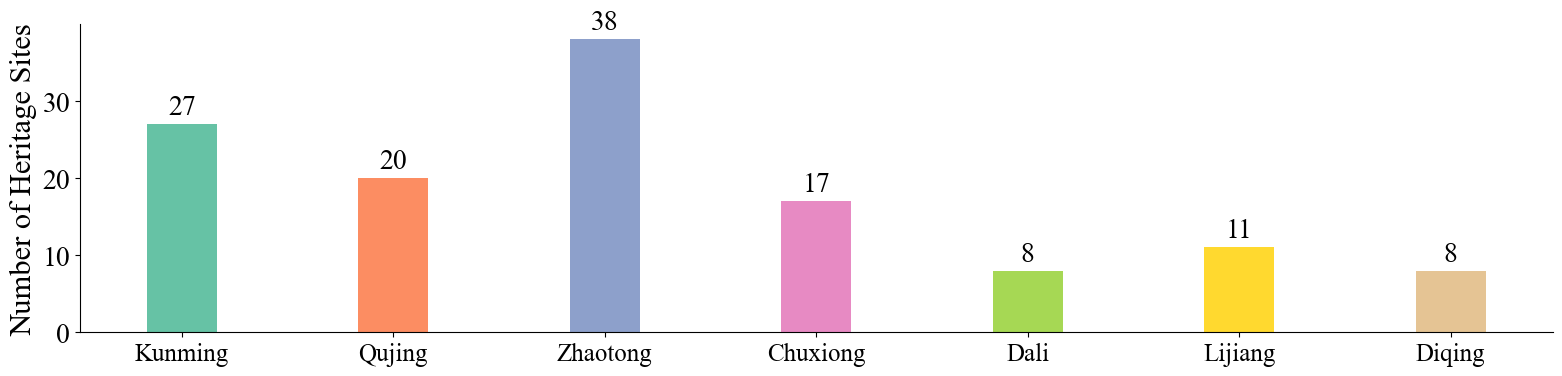

In [ ]:
# 数量分布统计
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

# 设置中文和英文字体
# zh_font = font_manager.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")  # 宋体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

# 城市顺序和对应景区数量
city_order = ['Kunming', 'Qujing', 'Zhaotong', 'Chuxiong', 'Dali', 'Lijiang', 'Diqing']
site_counts = [27, 20, 38, 17, 8, 11, 8]

# 配色方案（Set2 调色板）
palette = sns.color_palette("Set2", n_colors=len(city_order))
color_map = {city: palette[i] for i, city in enumerate(city_order)}
colors = [color_map[city] for city in city_order]

# 创建图形
fig, ax = plt.subplots(figsize=(19, 4))

# 绘制柱状图
bars = ax.bar(city_order, site_counts, width=0.33, color=colors)

# 设置轴标签（加大字体）
ax.set_ylabel('Number of Heritage Sites', fontsize=22)
ax.set_xticks(range(len(city_order)))
ax.set_xticklabels(city_order, fontsize=18, rotation=0)
ax.tick_params(axis='y', labelsize=20)

# 添加柱头整数标签
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{int(height)}',
            ha='center', va='bottom', fontsize=20)

# 隐藏顶部和右侧边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 设置背景透明保存
plt.savefig("长征景区数量.png", dpi=720, bbox_inches='tight', transparent=True)
plt.show()

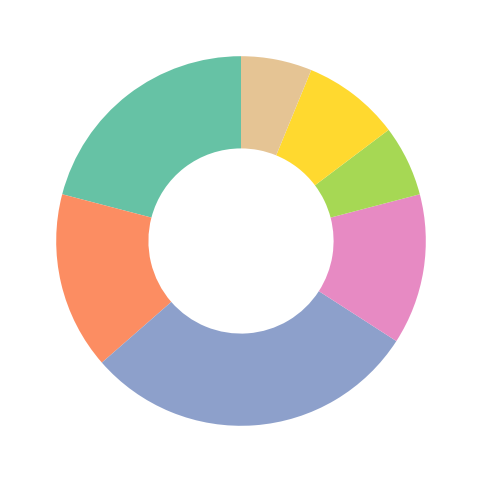

In [ ]:
# 甜甜圈图
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

# 设置字体
zh_font = font_manager.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")  # 宋体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False

# 数据
city_order = ['昆明', '曲靖', '昭通', '楚雄', '大理', '丽江', '迪庆']
site_counts = [27, 20, 38, 17, 8, 11, 8]

# 颜色映射
palette = sns.color_palette("Set2", n_colors=len(city_order))
colors = [palette[i] for i in range(len(city_order))]

# 绘图
fig, ax = plt.subplots(figsize=(6, 6))

# 绘制透明中心甜甜圈
wedges, _ = ax.pie(
    site_counts,
    colors=colors,
    startangle=90,
    wedgeprops=dict(width=0.499, edgecolor='none')  # 控制甜甜圈厚度，中心直接透明
)

# 设置等比 & 去除坐标轴
ax.set(aspect="equal")
plt.axis('off')

# 保存为透明背景图（包括中心空心）
plt.savefig("长征景区_甜甜圈图_完全透明中心.png", dpi=600, bbox_inches='tight', transparent=True)
plt.show()

d:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


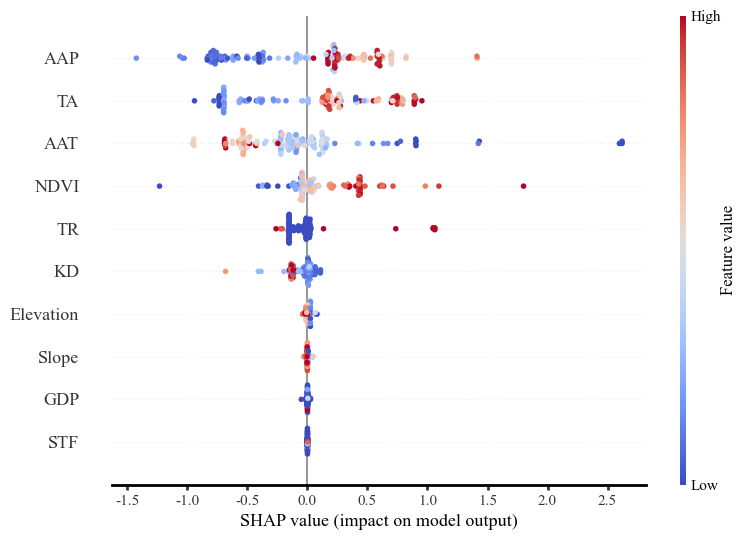

In [ ]:
# SHAP分析点分布图
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
from matplotlib.cm import ScalarMappable
from matplotlib import font_manager

# 设置字体：中文宋体 + 英文 Times New Roman
zh_font = font_manager.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")  # 宋体
plt.rcParams['font.family'] = 'Times New Roman'  # 英文
plt.rcParams['axes.unicode_minus'] = False  # 负号

# 1. 读取数据
file_path = r"C:\Users\leishen\Desktop\sample.xlsx"
df = pd.read_excel(file_path)

# 2. 选择指定列
selected_cols = [
    "TA", "KD", "GDP", "AAT",
    "NDVI", "AAP", "Elevation", "Slope", "TR", "STF"
]
data = df[selected_cols].copy()

# 3. 负向指标正向化（交通可达性、坡度）
neg_cols = ["TA", "Slope"]
for col in neg_cols:
    data[col] = data[col].max() - data[col]

# 4. Min-Max 标准化（缩放到0~1）
scaler = MinMaxScaler()
data_std = scaler.fit_transform(data)

# 5. 平移处理（整体+1，使其变为 1~2 范围）
data_shifted = data_std + 1

# 6. KMeans聚类分级（等级：1~5）
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_shifted)
cluster_labels = clusters + 1  # 标签从1~5

# 7. XGBoost训练，计算特征权重
xgb_model = XGBRegressor(n_estimators=100, random_state=41)
xgb_model.fit(data_shifted, cluster_labels)
feature_importances = xgb_model.feature_importances_

# 8. 输出特征权重（按大小排序）
feature_weight_dict = dict(zip(selected_cols, feature_importances))
sorted_weights = sorted(feature_weight_dict.items(), key=lambda x: x[1], reverse=True)

# 9. 加权得分（使用 Min-Max 标准化后的数据，不是平移后的）
weighted_score = data_std @ feature_importances

# ✅ 乘以 100 放大得分
weighted_score = weighted_score * 100

# 10. 添加得分列并写回Excel
df["总分值"] = weighted_score
df.to_excel(file_path, index=False)

# ——— 新增：基于训练好的xgb模型做SHAP解释 ———
explainer = shap.Explainer(xgb_model)
shap_values = explainer(data_shifted)

# 计算每个特征的平均绝对SHAP值（重要度）
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
features = selected_cols

# 排序（降序），确保顶部最大
sorted_idx = np.argsort(mean_abs_shap)[::-1]
mean_abs_shap_sorted = mean_abs_shap[sorted_idx]
features_sorted = [features[i] for i in sorted_idx]

# 设置颜色条（从低到高）
cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(vmin=np.min(mean_abs_shap_sorted), vmax=np.max(mean_abs_shap_sorted))

# 准备绘制多个图形
fig = plt.figure(figsize=(18, 14))

# 画左侧的主要条形图和径向图（a部分）
# 设置主条形图
ax_bar = fig.add_axes([0.08, 0.15, 0.6, 0.75])
bars = ax_bar.barh(
    features_sorted[::-1],           # 反转顺序，确保最大值在上
    mean_abs_shap_sorted[::-1],      # 反转顺序对应
    color=ScalarMappable(cmap=cmap, norm=norm).to_rgba(mean_abs_shap_sorted[::-1]),  # 使用色彩条
    edgecolor='black',               # 黑色边框
    linewidth=1.5
)

# 添加SHAP值标签
for bar, val in zip(bars, mean_abs_shap_sorted[::-1]):
    width = bar.get_width()
    ax_bar.text(
        width + 0.002,                # 稍微向右偏移一点，避免重叠柱子
        bar.get_y() + bar.get_height() / 2,
        f"{val:.3f}",
        ha='left', va='center',
        fontsize=16,
        color='black'
    )

# 设置x轴标签和标题
ax_bar.set_xlabel("Mean Absolute SHAP Value", fontsize=18)
ax_bar.set_title("SHAP Feature Importance (Contribution to Model Output)", fontsize=22)

# 设置坐标轴样式
ax_bar.set_yticks(np.arange(len(features_sorted)))
ax_bar.set_yticklabels(features_sorted[::-1], fontsize=16)
ax_bar.tick_params(axis='x', labelsize=19, width=0.1)  # 调整x轴刻度线的宽度
ax_bar.xaxis.set_tick_params(width=0.2)  # 更精细的控制x轴线条的宽度
ax_bar.spines['bottom'].set_linewidth(0.2)  # 调整x轴框架线的粗细

# 设置色条
sm = ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax_bar, orientation='vertical', fraction=0.4, pad=0.4)  # 增加fraction和pad使色条更宽
cbar.set_label('Feature Value', size=16, labelpad=-41)  # 调整label位置，使其向左移动

# 设置径向图（内嵌图）
ax_radial_inset = fig.add_axes([0.7, 0.55, 0.25, 0.25], polar=True)
angles = np.linspace(0, 2 * np.pi, len(features_sorted), endpoint=False).tolist()
angles += angles[:1]

ax_radial_inset.set_theta_offset(np.pi / 2)
ax_radial_inset.set_theta_direction(-1)
ax_radial_inset.set_ylim(0, max(mean_abs_shap_sorted))

for i in range(len(features_sorted)):
    ax_radial_inset.bar(angles[i], mean_abs_shap_sorted[i], width=0.3, color=ScalarMappable(cmap=cmap, norm=norm).to_rgba(mean_abs_shap_sorted[i]))

ax_radial_inset.set_xticks(angles[:-1])
ax_radial_inset.set_xticklabels(features_sorted, fontsize=10)

# 画右侧SHAP摘要图（b部分）
ax_beeswarm = fig.add_axes([0.77, 0.15, 0.2, 0.75])  # 设置右侧摘要图的位置
shap.summary_plot(shap_values, data, plot_type="dot", show=False, cmap=cmap, max_display=10)

# 设置右侧SHAP摘要图的标题
ax_beeswarm.set_title("(b)", fontsize=30, weight='bold', ha='right', va='top')

# 保存最终图像
plt.tight_layout()
plt.savefig("shap_feature_importance_combined_style.png", dpi=720)
plt.show()

d:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


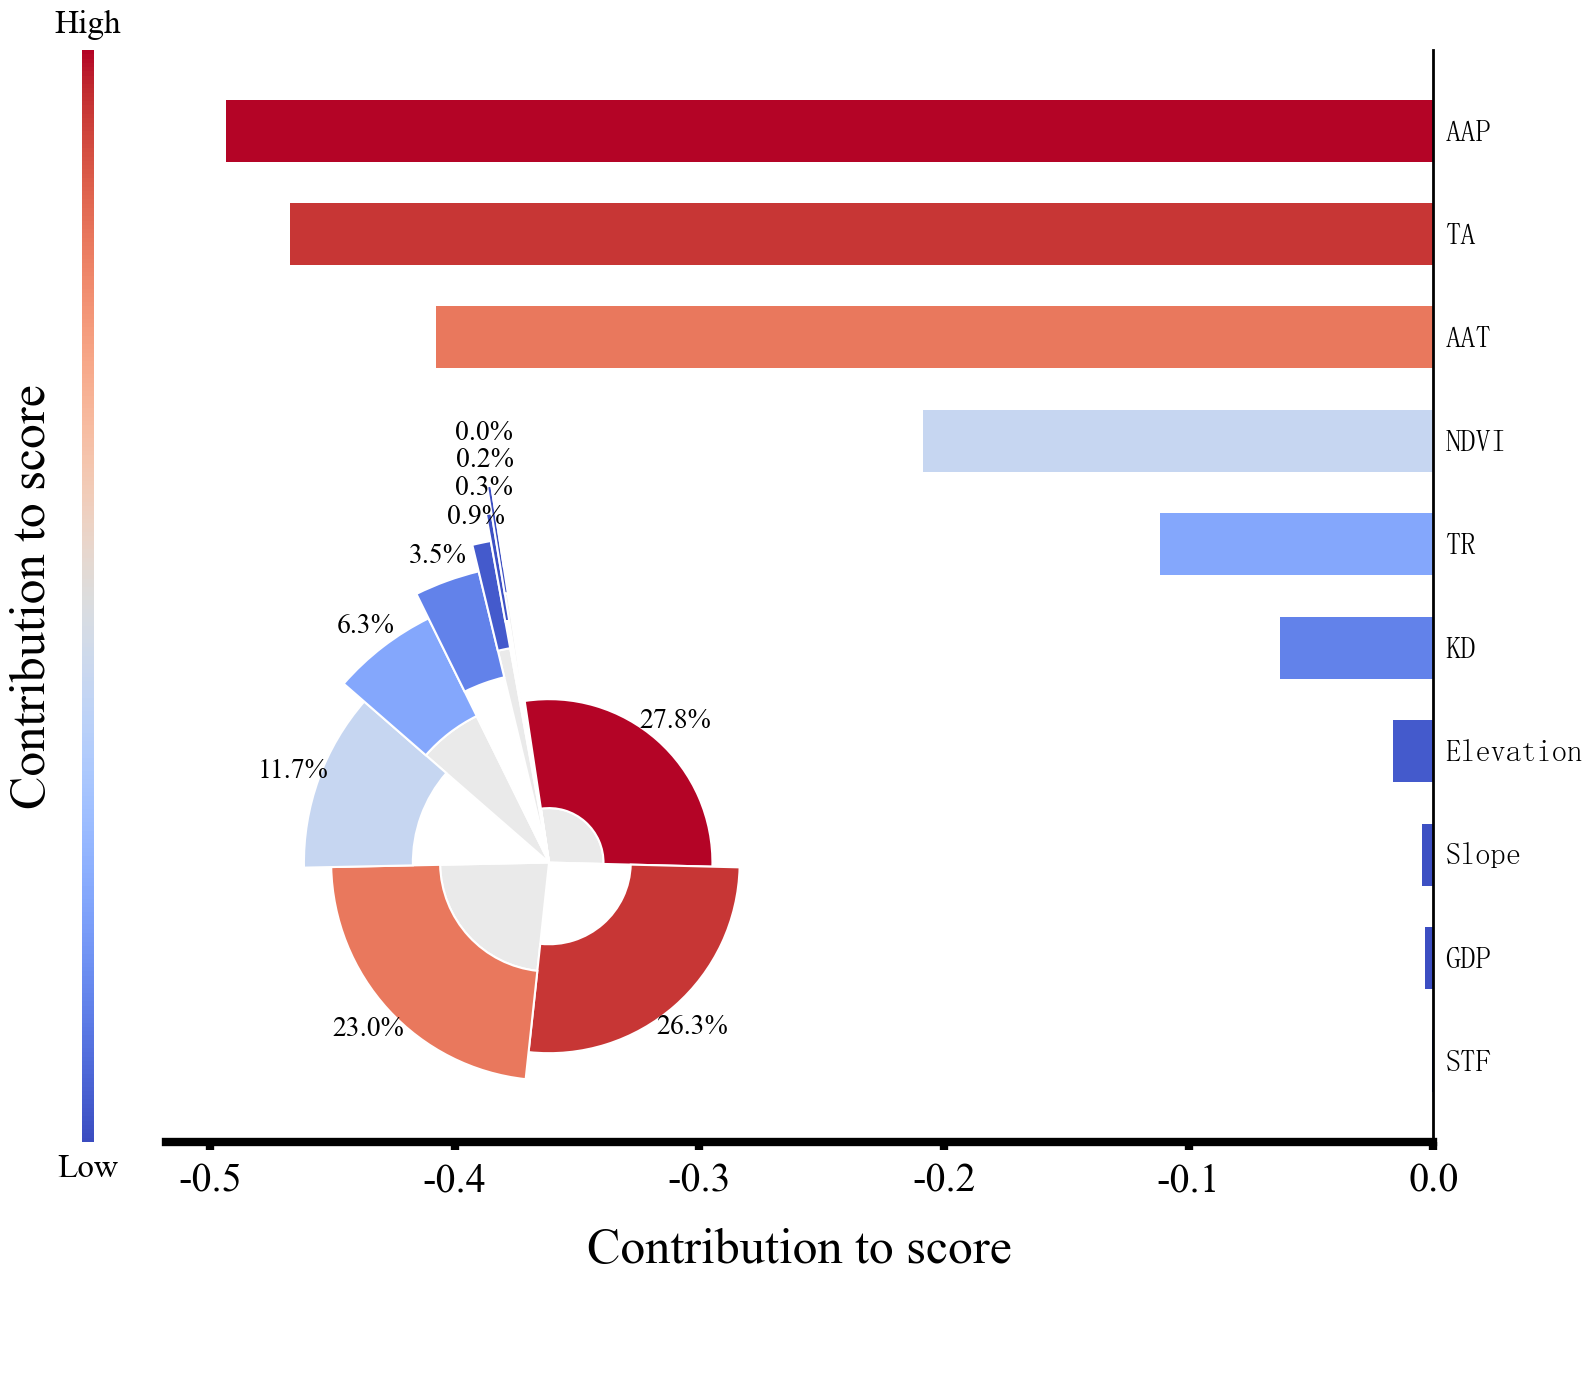

In [ ]:
# 混合模式指标SHAP分析玫瑰图
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
import shap
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.font_manager as fm

# ===================================================================
# 1. 数据准备部分（保持原样）
# ===================================================================
# 设置字体：中文宋体 + 英文 Times New Roman
zh_font = fm.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")  # 宋体
plt.rcParams['font.family'] = 'Times New Roman'  # 英文
plt.rcParams['axes.unicode_minus'] = False  # 负号

# 读取数据
file_path = r"C:\Users\leishen\Desktop\sample.xlsx"
df = pd.read_excel(file_path)

# 选择指定列
selected_cols = ["TA", "KD", "GDP", "AAT", "NDVI", "AAP", "Elevation", "Slope", "TR", "STF"]
data = df[selected_cols].copy()

# 负向指标正向化（交通可达性、坡度）
neg_cols = ["TA", "Slope"]
for col in neg_cols:
    data[col] = data[col].max() - data[col]

# Min-Max 标准化（缩放到0~1）
scaler = MinMaxScaler()
data_std = scaler.fit_transform(data)

# 平移处理（整体+1，使其变为 1~2 范围）
data_shifted = data_std + 1

# KMeans聚类分级（等级：1~5）
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_shifted)
cluster_labels = clusters + 1  # 标签从1~5

# XGBoost训练
xgb_model = XGBRegressor(n_estimators=100, random_state=41)
xgb_model.fit(data_shifted, cluster_labels)

# SHAP分析
explainer = shap.Explainer(xgb_model)
shap_values = explainer(data_shifted)

# 计算每个特征的平均绝对SHAP值
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
features = selected_cols

# 排序（降序）
sorted_idx = np.argsort(mean_abs_shap)[::-1]
sorted_shap_values = mean_abs_shap[sorted_idx]
sorted_features = [features[i] for i in sorted_idx]

# ===================================================================
# 2. 可视化部分（按照参考图样式改造）
# ===================================================================
# 全局设置
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

# 创建颜色映射（使用 coolwarm 色图）
cmap = plt.get_cmap('coolwarm')  # 使用 coolwarm 色图
color_norm = mcolors.Normalize(vmin=min(sorted_shap_values), vmax=max(sorted_shap_values))
colors = [cmap(color_norm(val)) for val in sorted_shap_values]

# 创建画布
fig = plt.figure(figsize=(24, 14))

# =======================================================
# 左图 (a): 组合条形图和径向图
# =======================================================
# 定义布局参数
left_margin, right_margin = 0.05, 0.05
bottom_margin, top_margin = 0.12, 0.1
space_between = 0.02
plot_bottom = bottom_margin
plot_height = 1 - bottom_margin - top_margin
total_plot_width = 1 - left_margin - right_margin - space_between
left_plot_width = total_plot_width * 0.6

# 1. 颜色条
cbar_left = left_margin
colorbar_width = 0.005
ax_cbar = fig.add_axes([cbar_left, plot_bottom, colorbar_width, plot_height])
sm = ScalarMappable(cmap=cmap, norm=color_norm)
cbar = fig.colorbar(sm, cax=ax_cbar, orientation='vertical')
cbar.set_label('', size=24, labelpad=5)
cbar.set_ticks([])  # 隐藏色条的 ticks
cbar.ax.yaxis.set_ticks_position('left')
ax_cbar.text(0.5, 1.01, 'High', transform=ax_cbar.transAxes, 
             ha='center', va='bottom', fontsize=24)
ax_cbar.text(0.5, -0.01, 'Low', transform=ax_cbar.transAxes, 
             ha='center', va='top', fontsize=24)
cbar.outline.set_visible(False)
ax_cbar.text(-6, 0.5, 'Contribution to score', 
             transform=ax_cbar.transAxes, fontsize=36, rotation=90, va='center')

# 2. 主条形图
main_ax_left = cbar_left + colorbar_width + 0.03
ax_bar = fig.add_axes([main_ax_left, plot_bottom, left_plot_width, plot_height])

# 交换柱状图的方向，从右向左显示
ax_bar.barh(y=range(len(sorted_features)), width=-np.array(sorted_shap_values), 
            color=colors, height=0.6)
ax_bar.invert_yaxis()
ax_bar.set_xlabel('Contribution to score', size=36, labelpad=20)
ax_bar.set_yticks([])  # 去除Y轴文字标签
ax_bar.spines[['left', 'top']].set_visible(False)
ax_bar.spines['right'].set_position(('data', 0))
ax_bar.spines['right'].set_visible(True)
ax_bar.spines['bottom'].set_visible(True)
ax_bar.tick_params(axis='x', which='major', labelsize=29, length=6, pad=8)

# --- 加粗x轴线条 ---
ax_bar.spines['bottom'].set_linewidth(6)  # 更粗的x轴线条

# 设置刻度线宽度
ax_bar.tick_params(axis='x', width=6)  # 更粗的x轴刻度线

# 添加特征标签
label_x_padding = 0.005
for i, feature in enumerate(sorted_features):
    ax_bar.text(label_x_padding, i, feature, ha='left', va='center', 
                color='black', fontsize=22, fontproperties=zh_font)

# 3. 径向图
inset_size = min(left_plot_width, plot_height) * 1.4
inset_left = main_ax_left - 0.21
inset_bottom = plot_bottom - 0.17
ax_radial = fig.add_axes([inset_left, inset_bottom, inset_size, inset_size], 
                         projection='polar')
ax_radial.patch.set_alpha(0)

# 计算百分比和角度
percentages = (sorted_shap_values / sorted_shap_values.sum()) * 100
widths = (sorted_shap_values / sorted_shap_values.sum()) * 2 * np.pi
num_vars = len(sorted_features)
base_length, fixed_increment, colored_ring_width = 3.0, 0.5, 2.0
total_lengths = [base_length + i * fixed_increment for i in range(num_vars)]
inner_heights = [max(0, tl - colored_ring_width) for tl in total_lengths]
inner_colors = ['#EAEAEA', '#FFFFFF'] * (num_vars // 2 + 1)
inner_colors = inner_colors[:num_vars]
thetas = np.cumsum([0] + widths[:-1].tolist()) - np.pi/21

# 绘制径向图
ax_radial.bar(x=thetas, height=inner_heights, width=widths, 
              color=inner_colors, align='edge', edgecolor='white', linewidth=1.5)
ax_radial.bar(x=thetas, height=[colored_ring_width]*num_vars, width=widths, 
              bottom=inner_heights, color=colors, align='edge', edgecolor='white', linewidth=1.5)

# 添加百分比标签
for i in range(num_vars):
    label_angle = thetas[i] + widths[i]/2
    label_radius = total_lengths[i] + 0.5
    ax_radial.text(label_angle, label_radius, f'{percentages[i]:.1f}%', 
                   ha='center', va='center', fontsize=20)

ax_radial.set_yticks([])  # 去除Y轴刻度
ax_radial.set_yticklabels([])  # 去除Y轴标签
ax_radial.set_xticklabels([])
ax_radial.spines['polar'].set_visible(False)
ax_radial.grid(False)
ax_radial.set_theta_zero_location('N')
ax_radial.set_theta_direction(-1)
ax_radial.set_ylim(0, max(total_lengths) + 2)

# =======================================================
# 保存和显示
# =======================================================
plt.savefig("combined_shap_plot_updated_with_coolwarm.png", dpi=600, bbox_inches='tight')
plt.show()

d:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


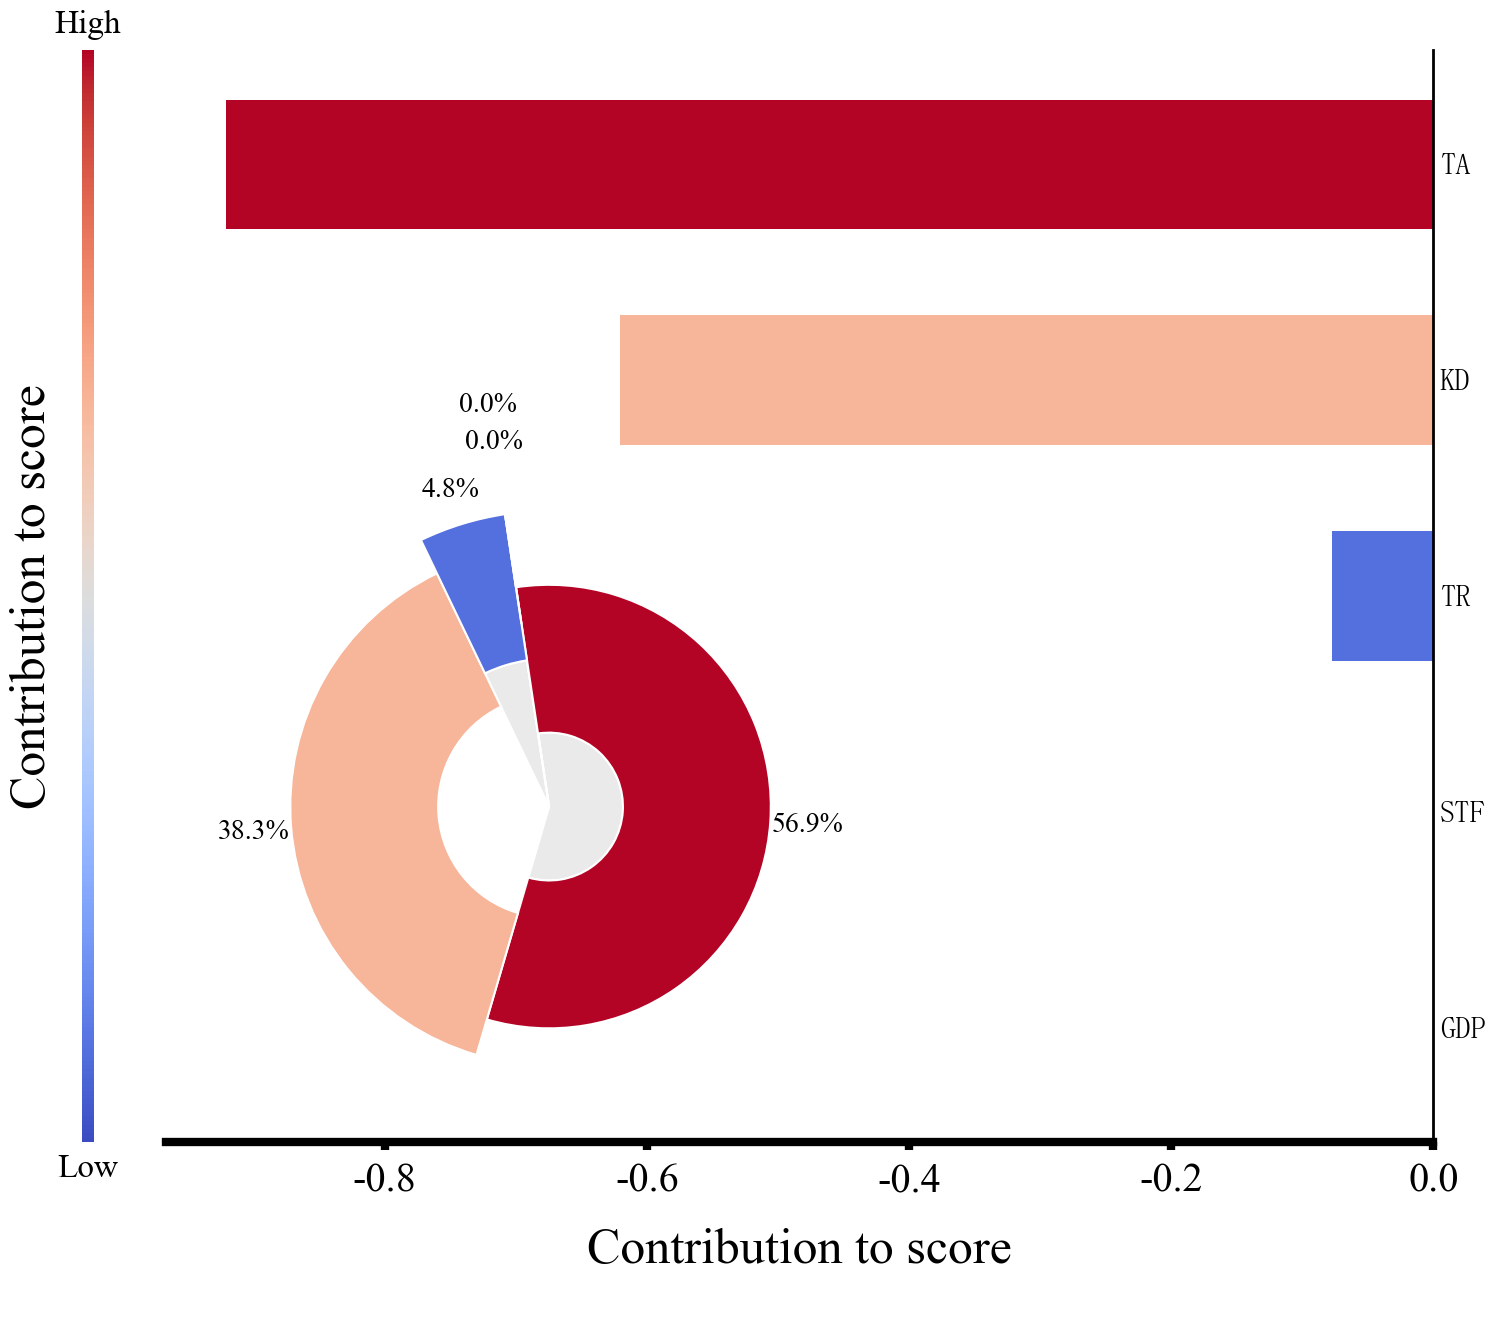

In [ ]:
# 社会模式指标SHAP分析玫瑰图
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
import shap
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.font_manager as fm

# ===================================================================
# 1. 数据准备部分（保持原样）
# ===================================================================
# 设置字体：中文宋体 + 英文 Times New Roman
zh_font = fm.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")  # 宋体
plt.rcParams['font.family'] = 'Times New Roman'  # 英文
plt.rcParams['axes.unicode_minus'] = False  # 负号

# 1. 读取数据
file_path = r"C:\Users\leishen\Desktop\sample.xlsx"
df = pd.read_excel(file_path)

# 2. 选择指定列
selected_cols = [
    "TA", "KD", "GDP", "TR", "STF"
]
data = df[selected_cols].copy()

# 3. 负向指标正向化（交通可达性、坡度）
neg_cols = ["TA"]
for col in neg_cols:
    data[col] = data[col].max() - data[col]

# Min-Max 标准化（缩放到0~1）
scaler = MinMaxScaler()
data_std = scaler.fit_transform(data)

# 平移处理（整体+1，使其变为 1~2 范围）
data_shifted = data_std + 1

# KMeans聚类分级（等级：1~5）
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_shifted)
cluster_labels = clusters + 1  # 标签从1~5

# XGBoost训练
xgb_model = XGBRegressor(n_estimators=100, random_state=41)
xgb_model.fit(data_shifted, cluster_labels)

# SHAP分析
explainer = shap.Explainer(xgb_model)
shap_values = explainer(data_shifted)

# 计算每个特征的平均绝对SHAP值
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
features = selected_cols

# 排序（降序）
sorted_idx = np.argsort(mean_abs_shap)[::-1]
sorted_shap_values = mean_abs_shap[sorted_idx]
sorted_features = [features[i] for i in sorted_idx]

# ===================================================================
# 2. 可视化部分（按照参考图样式改造）
# ===================================================================
# 全局设置
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

# 创建颜色映射（使用 coolwarm 色图）
cmap = plt.get_cmap('coolwarm')  # 使用 coolwarm 色图
color_norm = mcolors.Normalize(vmin=min(sorted_shap_values), vmax=max(sorted_shap_values))
colors = [cmap(color_norm(val)) for val in sorted_shap_values]

# 创建画布
fig = plt.figure(figsize=(24, 14))

# =======================================================
# 左图 (a): 组合条形图和径向图
# =======================================================
# 定义布局参数
left_margin, right_margin = 0.05, 0.05
bottom_margin, top_margin = 0.12, 0.1
space_between = 0.02
plot_bottom = bottom_margin
plot_height = 1 - bottom_margin - top_margin
total_plot_width = 1 - left_margin - right_margin - space_between
left_plot_width = total_plot_width * 0.6

# 1. 颜色条
cbar_left = left_margin
colorbar_width = 0.005
ax_cbar = fig.add_axes([cbar_left, plot_bottom, colorbar_width, plot_height])
sm = ScalarMappable(cmap=cmap, norm=color_norm)
cbar = fig.colorbar(sm, cax=ax_cbar, orientation='vertical')
cbar.set_label('', size=24, labelpad=5)
cbar.set_ticks([])  # 隐藏色条的 ticks
cbar.ax.yaxis.set_ticks_position('left')
ax_cbar.text(0.5, 1.01, 'High', transform=ax_cbar.transAxes, 
             ha='center', va='bottom', fontsize=24)
ax_cbar.text(0.5, -0.01, 'Low', transform=ax_cbar.transAxes, 
             ha='center', va='top', fontsize=24)
cbar.outline.set_visible(False)
ax_cbar.text(-6, 0.5, 'Contribution to score', 
             transform=ax_cbar.transAxes, fontsize=36, rotation=90, va='center')

# 2. 主条形图
main_ax_left = cbar_left + colorbar_width + 0.03
ax_bar = fig.add_axes([main_ax_left, plot_bottom, left_plot_width, plot_height])

# 交换柱状图的方向，从右向左显示
ax_bar.barh(y=range(len(sorted_features)), width=-np.array(sorted_shap_values), 
            color=colors, height=0.6)
ax_bar.invert_yaxis()
ax_bar.set_xlabel('Contribution to score', size=36, labelpad=20)
ax_bar.set_yticks([])  # 去除Y轴文字标签
ax_bar.spines[['left', 'top']].set_visible(False)
ax_bar.spines['right'].set_position(('data', 0))
ax_bar.spines['right'].set_visible(True)
ax_bar.spines['bottom'].set_visible(True)
ax_bar.tick_params(axis='x', which='major', labelsize=29, length=6, pad=8)

# --- 加粗x轴线条 ---
ax_bar.spines['bottom'].set_linewidth(6)  # 更粗的x轴线条

# 设置刻度线宽度
ax_bar.tick_params(axis='x', width=6)  # 更粗的x轴刻度线

# 添加特征标签
label_x_padding = 0.005
for i, feature in enumerate(sorted_features):
    ax_bar.text(label_x_padding, i, feature, ha='left', va='center', 
                color='black', fontsize=22, fontproperties=zh_font)

# 3. 径向图
inset_size = min(left_plot_width, plot_height) * 1.4
inset_left = main_ax_left - 0.21
inset_bottom = plot_bottom - 0.13
ax_radial = fig.add_axes([inset_left, inset_bottom, inset_size, inset_size], 
                         projection='polar')
ax_radial.patch.set_alpha(0)

# 计算百分比和角度
percentages = (sorted_shap_values / sorted_shap_values.sum()) * 100
widths = (sorted_shap_values / sorted_shap_values.sum()) * 2 * np.pi
num_vars = len(sorted_features)
base_length, fixed_increment, colored_ring_width = 3.0, 0.5, 2.0
total_lengths = [base_length + i * fixed_increment for i in range(num_vars)]
inner_heights = [max(0, tl - colored_ring_width) for tl in total_lengths]
inner_colors = ['#EAEAEA', '#FFFFFF'] * (num_vars // 2 + 1)
inner_colors = inner_colors[:num_vars]
thetas = np.cumsum([0] + widths[:-1].tolist()) - np.pi/21

# 绘制径向图
ax_radial.bar(x=thetas, height=inner_heights, width=widths, 
              color=inner_colors, align='edge', edgecolor='white', linewidth=1.5)
ax_radial.bar(x=thetas, height=[colored_ring_width]*num_vars, width=widths, 
              bottom=inner_heights, color=colors, align='edge', edgecolor='white', linewidth=1.5)

# 添加百分比标签
for i in range(num_vars):
    label_angle = thetas[i] + widths[i]/2
    label_radius = total_lengths[i] + 0.5
    ax_radial.text(label_angle, label_radius, f'{percentages[i]:.1f}%', 
                   ha='center', va='center', fontsize=20)

ax_radial.set_yticks([])  # 去除Y轴刻度
ax_radial.set_yticklabels([])  # 去除Y轴标签
ax_radial.set_xticklabels([])
ax_radial.spines['polar'].set_visible(False)
ax_radial.grid(False)
ax_radial.set_theta_zero_location('N')
ax_radial.set_theta_direction(-1)
ax_radial.set_ylim(0, max(total_lengths) + 2)

# =======================================================
# 保存和显示
# =======================================================
plt.savefig("combined_shap_plot_updated_with_coolwarm.png", dpi=300, bbox_inches='tight')
plt.show()

d:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


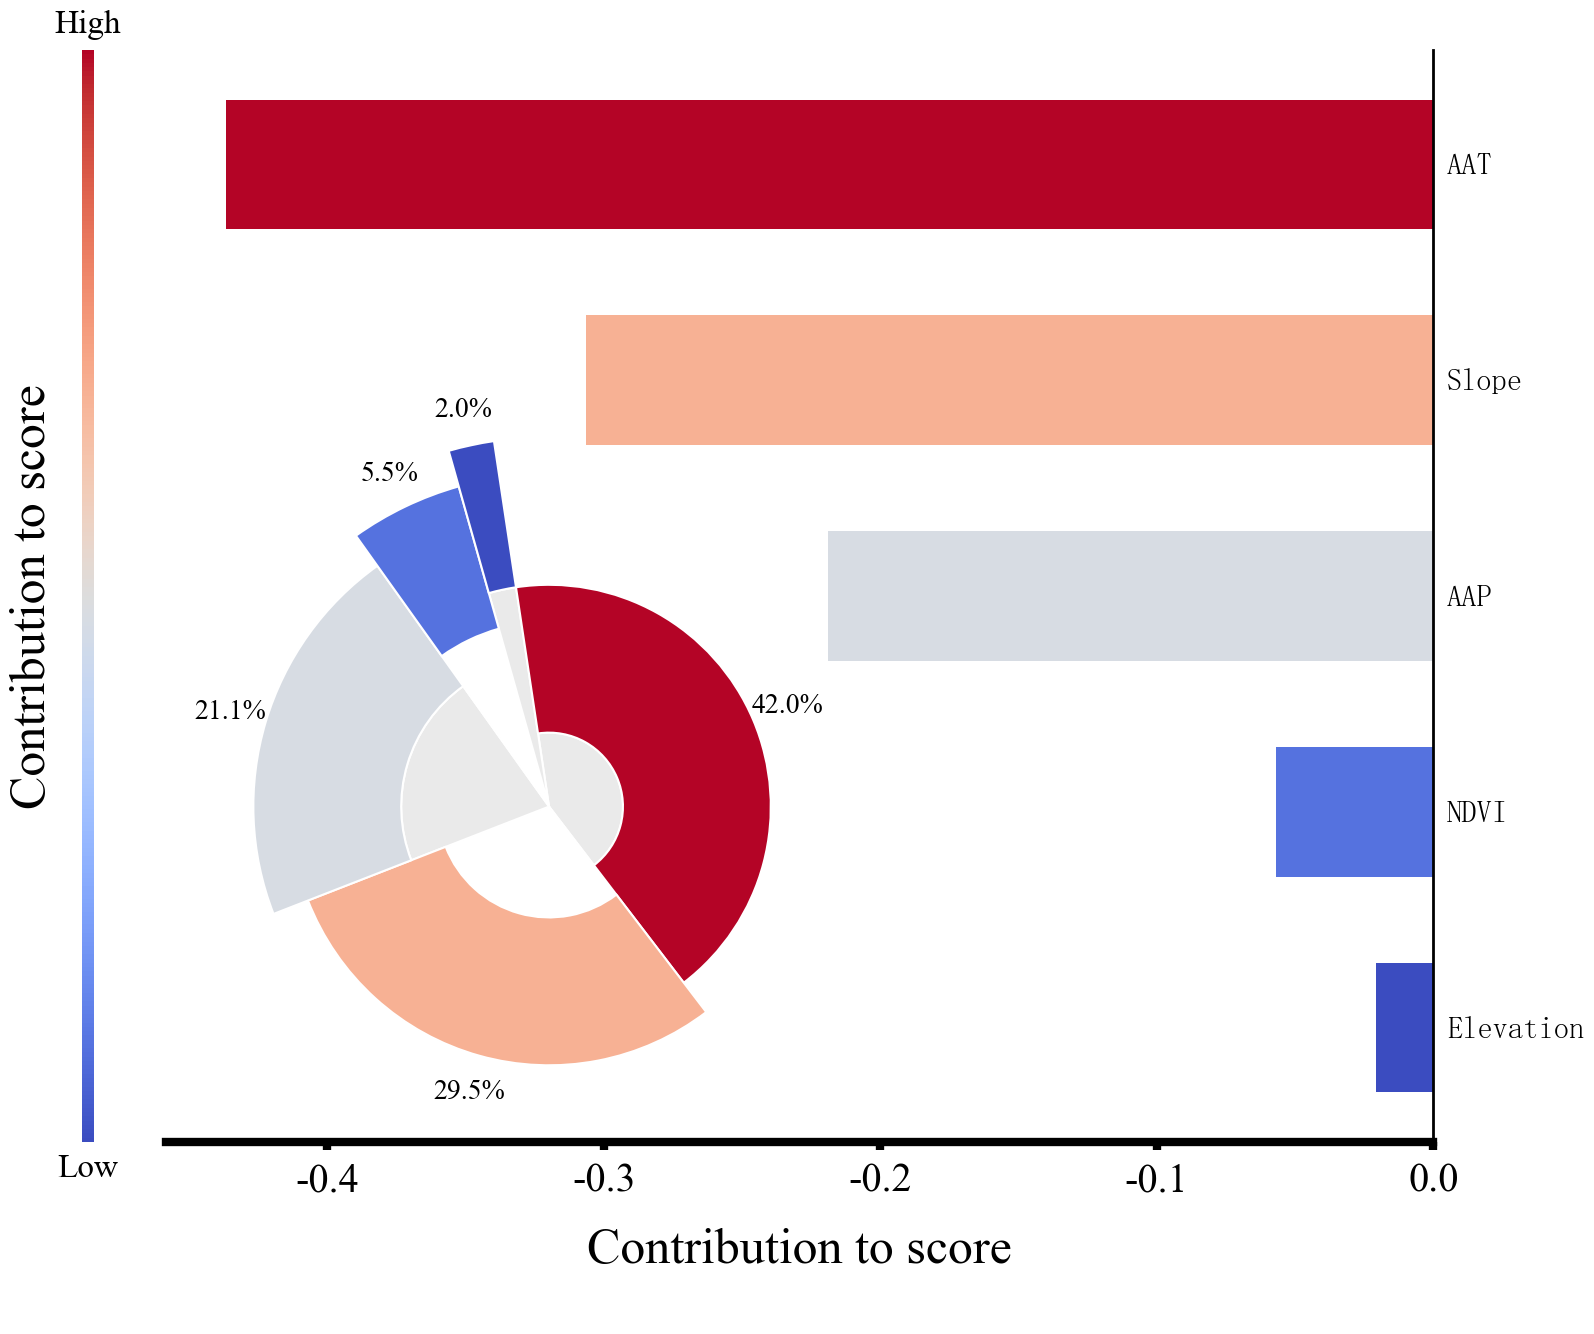

In [ ]:
# 生态模式指标SHAP分析玫瑰图
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable
import shap
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.font_manager as fm

# ===================================================================
# 1. 数据准备部分（保持原样）
# ===================================================================
# 设置字体：中文宋体 + 英文 Times New Roman
zh_font = fm.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")  # 宋体
plt.rcParams['font.family'] = 'Times New Roman'  # 英文
plt.rcParams['axes.unicode_minus'] = False  # 负号

# 1. 读取数据
file_path = r"C:\Users\leishen\Desktop\sample.xlsx"
df = pd.read_excel(file_path)

# 2. 选择指定列
selected_cols = [
    "AAT", "NDVI", "AAP", "Elevation", "Slope"
]
data = df[selected_cols].copy()

# 3. 负向指标正向化（交通可达性、坡度）
neg_cols = ["Slope"]
for col in neg_cols:
    data[col] = data[col].max() - data[col]

# Min-Max 标准化（缩放到0~1）
scaler = MinMaxScaler()
data_std = scaler.fit_transform(data)

# 平移处理（整体+1，使其变为 1~2 范围）
data_shifted = data_std + 1

# KMeans聚类分级（等级：1~5）
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(data_shifted)
cluster_labels = clusters + 1  # 标签从1~5

# XGBoost训练
xgb_model = XGBRegressor(n_estimators=100, random_state=41)
xgb_model.fit(data_shifted, cluster_labels)

# SHAP分析
explainer = shap.Explainer(xgb_model)
shap_values = explainer(data_shifted)

# 计算每个特征的平均绝对SHAP值
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
features = selected_cols

# 排序（降序）
sorted_idx = np.argsort(mean_abs_shap)[::-1]
sorted_shap_values = mean_abs_shap[sorted_idx]
sorted_features = [features[i] for i in sorted_idx]

# ===================================================================
# 2. 可视化部分（按照参考图样式改造）
# ===================================================================
# 全局设置
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2

# 创建颜色映射（使用 coolwarm 色图）
cmap = plt.get_cmap('coolwarm')  # 使用 coolwarm 色图
color_norm = mcolors.Normalize(vmin=min(sorted_shap_values), vmax=max(sorted_shap_values))
colors = [cmap(color_norm(val)) for val in sorted_shap_values]

# 创建画布
fig = plt.figure(figsize=(24, 14))

# =======================================================
# 左图 (a): 组合条形图和径向图
# =======================================================
# 定义布局参数
left_margin, right_margin = 0.05, 0.05
bottom_margin, top_margin = 0.12, 0.1
space_between = 0.02
plot_bottom = bottom_margin
plot_height = 1 - bottom_margin - top_margin
total_plot_width = 1 - left_margin - right_margin - space_between
left_plot_width = total_plot_width * 0.6

# 1. 颜色条
cbar_left = left_margin
colorbar_width = 0.005
ax_cbar = fig.add_axes([cbar_left, plot_bottom, colorbar_width, plot_height])
sm = ScalarMappable(cmap=cmap, norm=color_norm)
cbar = fig.colorbar(sm, cax=ax_cbar, orientation='vertical')
cbar.set_label('', size=24, labelpad=5)
cbar.set_ticks([])  # 隐藏色条的 ticks
cbar.ax.yaxis.set_ticks_position('left')
ax_cbar.text(0.5, 1.01, 'High', transform=ax_cbar.transAxes, 
             ha='center', va='bottom', fontsize=24)
ax_cbar.text(0.5, -0.01, 'Low', transform=ax_cbar.transAxes, 
             ha='center', va='top', fontsize=24)
cbar.outline.set_visible(False)
ax_cbar.text(-6, 0.5, 'Contribution to score', 
             transform=ax_cbar.transAxes, fontsize=36, rotation=90, va='center')

# 2. 主条形图
main_ax_left = cbar_left + colorbar_width + 0.03
ax_bar = fig.add_axes([main_ax_left, plot_bottom, left_plot_width, plot_height])

# 交换柱状图的方向，从右向左显示
ax_bar.barh(y=range(len(sorted_features)), width=-np.array(sorted_shap_values), 
            color=colors, height=0.6)
ax_bar.invert_yaxis()
ax_bar.set_xlabel('Contribution to score', size=36, labelpad=20)
ax_bar.set_yticks([])  # 去除Y轴文字标签
ax_bar.spines[['left', 'top']].set_visible(False)
ax_bar.spines['right'].set_position(('data', 0))
ax_bar.spines['right'].set_visible(True)
ax_bar.spines['bottom'].set_visible(True)
ax_bar.tick_params(axis='x', which='major', labelsize=29, length=6, pad=8)

# --- 加粗x轴线条 ---
ax_bar.spines['bottom'].set_linewidth(6)  # 更粗的x轴线条

# 设置刻度线宽度
ax_bar.tick_params(axis='x', width=6)  # 更粗的x轴刻度线

# 添加特征标签
label_x_padding = 0.005
for i, feature in enumerate(sorted_features):
    ax_bar.text(label_x_padding, i, feature, ha='left', va='center', 
                color='black', fontsize=22, fontproperties=zh_font)

# 3. 径向图
inset_size = min(left_plot_width, plot_height) * 1.4
inset_left = main_ax_left - 0.21
inset_bottom = plot_bottom - 0.13
ax_radial = fig.add_axes([inset_left, inset_bottom, inset_size, inset_size], 
                         projection='polar')
ax_radial.patch.set_alpha(0)

# 计算百分比和角度
percentages = (sorted_shap_values / sorted_shap_values.sum()) * 100
widths = (sorted_shap_values / sorted_shap_values.sum()) * 2 * np.pi
num_vars = len(sorted_features)
base_length, fixed_increment, colored_ring_width = 3.0, 0.5, 2.0
total_lengths = [base_length + i * fixed_increment for i in range(num_vars)]
inner_heights = [max(0, tl - colored_ring_width) for tl in total_lengths]
inner_colors = ['#EAEAEA', '#FFFFFF'] * (num_vars // 2 + 1)
inner_colors = inner_colors[:num_vars]
thetas = np.cumsum([0] + widths[:-1].tolist()) - np.pi/21

# 绘制径向图
ax_radial.bar(x=thetas, height=inner_heights, width=widths, 
              color=inner_colors, align='edge', edgecolor='white', linewidth=1.5)
ax_radial.bar(x=thetas, height=[colored_ring_width]*num_vars, width=widths, 
              bottom=inner_heights, color=colors, align='edge', edgecolor='white', linewidth=1.5)

# 添加百分比标签
for i in range(num_vars):
    label_angle = thetas[i] + widths[i]/2
    label_radius = total_lengths[i] + 0.5
    ax_radial.text(label_angle, label_radius, f'{percentages[i]:.1f}%', 
                   ha='center', va='center', fontsize=20)

ax_radial.set_yticks([])  # 去除Y轴刻度
ax_radial.set_yticklabels([])  # 去除Y轴标签
ax_radial.set_xticklabels([])
ax_radial.spines['polar'].set_visible(False)
ax_radial.grid(False)
ax_radial.set_theta_zero_location('N')
ax_radial.set_theta_direction(-1)
ax_radial.set_ylim(0, max(total_lengths) + 2)

# =======================================================
# 保存和显示
# =======================================================
plt.savefig("combined_shap_plot_updated_with_coolwarm.png", dpi=300, bbox_inches='tight')
plt.show()